# Part II-1

In [2]:
import numpy as np

In [3]:
ratings=np.loadtxt("./data/ml-1m/ratings.dat",delimiter="::",dtype=int)

In [4]:
user_num=6040
movie_num=3952
rating_matrix=np.zeros((6040+1,3952+1))
for r in ratings:
    rating_matrix[r[0],r[1]]=r[2] #rating_matrix[userID,movieID]

In [5]:
# 分割为train & test
train_matrix=rating_matrix.copy()
test_user_size=rating_matrix.shape[0]//10
test_movie_size=rating_matrix.shape[1]//10

train_matrix[:test_user_size,:test_movie_size]=0

test_matrix=rating_matrix[:test_user_size,:test_movie_size].copy()

print(train_matrix.shape,test_matrix.shape,rating_matrix.shape)

(6041, 3953) (604, 395) (6041, 3953)


## Content-Based

In [6]:
#需要用到上面的数据
user_profile=np.zeros((test_user_size,user_num+1))
for i in range(test_user_size):
    user_profile[i]=np.sum(train_matrix*train_matrix[i],axis=1)
    if i%100==0:
        print(i)

0
100
200
300
400
500
600


In [7]:
cb_pred=np.zeros((test_user_size,test_movie_size))
for i in range(1,test_user_size):
    for j in range(1,test_movie_size):
        norm=np.linalg.norm(train_matrix[:,j])*np.linalg.norm(user_profile[i])
        if norm == 0:
            cb_pred[i,j]=0
        else:
            cb_pred[i,j]=((train_matrix[:,j]@user_profile[i])/(norm))*5

In [149]:
#result_matrix=np.zeros((test_user_size,test_movie_size))
#result_matrix2=np.zeros((test_user_size,test_movie_size))
#for i in range(test_user_size):
#    for j in range(test_movie_size):
#        if test_matrix[i,j]!=0:
#            result_matrix[i,j]=cb_pred[i,j]-test_matrix[i,j]

result_matrix2=cb_pred.copy()
result_matrix2[test_matrix==0]=0
result_matrix=result_matrix2-test_matrix

$$
RMSE=\sqrt{\frac{1}{n}\sum_{j=1}^n (y_j-\bar{y}_j)^2}
$$

In [150]:
#RMSE
np.linalg.norm(result_matrix)/np.count_nonzero(test_matrix)

0.016676901400536383

$$
MAE=\frac{1}{n}\sum_{j=1}^n|y_j-\bar{y}_j|
$$

In [151]:
#MAE
np.sum(np.absolute(result_matrix))/np.count_nonzero(test_matrix)

1.4344089529739494

In [154]:
N=10 #TopN
recommend_rate=3
pred=np.argsort(result_matrix2,axis=1)[:,-N:]
#truth=np.argsort(test_matrix,axis=1)[:,-N:]

Total_Right=0
index=np.arange(test_movie_size)
for i in range(test_user_size):
    #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]
    
    Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]
    
precision=Total_Right/(N*test_user_size)
recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]

print(precision,recall)

0.4870860927152318 0.49628879892037786


In [155]:
def Pred_of_N(N):
    recommend_rate=3
    pred=np.argsort(result_matrix2,axis=1)[:,-N:]
    #truth=np.argsort(test_matrix,axis=1)[:,-N:]

    Total_Right=0
    index=np.arange(test_movie_size)
    for i in range(test_user_size):
        #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]

        Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]

    precision=Total_Right/(N*test_user_size)
    recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]
    
    return precision,recall

In [156]:
PR=[Pred_of_N(N) for N in range(1,50)]

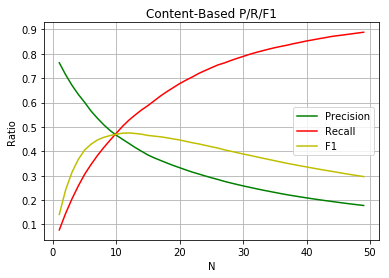

In [174]:
plt.figure(1)
plt.plot(range(1,50),[i[0] for i in PR],label="Precision",color="g")
plt.plot(range(1,50),[i[1] for i in PR],label="Recall",color="r")
plt.plot(range(1,50),[2*(i[0]*i[1])/(i[0]+i[1]) for i in PR],label="F1",color="y")
plt.title("Content-Based P/R/F1")
plt.xlabel("N")
plt.ylabel("Ratio")
plt.grid(True)
plt.legend()
plt.savefig("./graph/Content_based-PRF1_of_N.png")
plt.show()

## Collaborative Filtering

In [99]:
#需要用到上面的数据
print(train_matrix.shape,test_matrix.shape,rating_matrix.shape)

(6041, 3953) (604, 395) (6041, 3953)


In [104]:
movie_sim=np.zeros((movie_num+1,movie_num+1))
movie_bar=np.zeros(movie_num+1)

In [7]:
#无需重新运行
#item相似性 movie[i,j]表示电影i,j的相似性
for i in range(movie_num+1):
    ri=train_matrix[:,i]
    nonzero=np.count_nonzero(ri)
    if nonzero!=0:
        movie_bar[i]=ri.sum()/nonzero


for i in range(1,movie_num+1):
    print(i)
    for j in range(1,movie_num+1):
        if i>j:
            movie_sim[i,j]=movie_sim[j,i]
            continue
        ri=train_matrix[:,i]
        rj=train_matrix[:,j]
        
        rri=np.zeros(user_num+1)
        rrj=np.zeros(user_num+1)
        selected=np.logical_and(ri,rj)
        rri[selected]=ri[selected]-movie_bar[i]
        rrj[selected]=rj[selected]-movie_bar[j]
        
        norm=np.linalg.norm(rri)*np.linalg.norm(rrj)
        if norm==0:
            movie_sim[i,j]=0
        else:
            movie_sim[i,j]=(rri@rrj)/(norm)

np.save("./data/ml-1m/movie_sim.npy",movie_sim)

1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

In [105]:
movie_sim=np.load("./data/ml-1m/movie_sim.npy")
user_bar=np.zeros(user_num+1)
for i in range(user_num+1):
    ri=train_matrix[i]
    nonzero=np.count_nonzero(ri)
    if nonzero!=0:
        user_bar[i]=ri.sum()/nonzero

In [106]:
miu=train_matrix.sum()/np.count_nonzero(train_matrix)
bxi=user_bar.reshape(user_num+1,1)+movie_bar-miu

In [108]:
k=5
cf_pred=np.zeros((test_user_size,test_movie_size))

for x in range(1,test_user_size):
    if x%100==0:
        print(x)
    for i in range(1,test_movie_size):
        index=np.arange(movie_num+1)[train_matrix[x].astype("bool")]
        Nix=index[np.argsort(movie_sim[i,train_matrix[x].astype("bool")])[-k:]]
        
        sumij=movie_sim[i,Nix].sum()
        if sumij!=0:
            cf_pred[x,i]=bxi[x,i]+(movie_sim[i,Nix]@(train_matrix[x,Nix]-bxi[x,Nix]))/sumij

100
200
300
400
500
600


In [164]:
#result_matrix=np.zeros((test_user_size,test_movie_size))
#for i in range(test_user_size):
#    for j in range(test_movie_size):
#        if test_matrix[i,j]!=0:
#            result_matrix[i,j]=cf_pred[i,j]-test_matrix[i,j]
result_matrix2=cf_pred.copy()
result_matrix2[test_matrix==0]=0
result_matrix=result_matrix2-test_matrix

In [165]:
#RMSE
np.linalg.norm(result_matrix)/np.count_nonzero(test_matrix)

0.010776504401721263

In [166]:
#MAE
np.sum(np.absolute(result_matrix))/np.count_nonzero(test_matrix)

0.8694166710904666

In [167]:
N=10 #TopN
recommend_rate=3
pred=np.argsort(result_matrix2,axis=1)[:,-N:]
#truth=np.argsort(test_matrix,axis=1)[:,-N:]

Total_Right=0
index=np.arange(test_movie_size)
for i in range(test_user_size):
    #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]
    
    Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]
    
precision=Total_Right/(N*test_user_size)
recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]

print(precision,recall)

0.46589403973509935 0.47469635627530365


In [168]:
def Pred_of_N(N):
    recommend_rate=3
    pred=np.argsort(result_matrix2,axis=1)[:,-N:]
    #truth=np.argsort(test_matrix,axis=1)[:,-N:]

    Total_Right=0
    index=np.arange(test_movie_size)
    for i in range(test_user_size):
        #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]

        Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]

    precision=Total_Right/(N*test_user_size)
    recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]
    
    return precision,recall

In [169]:
PR=[Pred_of_N(N) for N in range(1,50)]

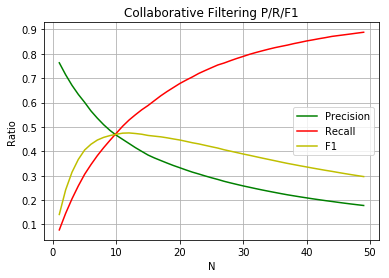

In [175]:
plt.figure(1)
plt.plot(range(1,50),[i[0] for i in PR],label="Precision",color="g")
plt.plot(range(1,50),[i[1] for i in PR],label="Recall",color="r")
plt.plot(range(1,50),[2*(i[0]*i[1])/(i[0]+i[1]) for i in PR],label="F1",color="y")
plt.title("Collaborative Filtering P/R/F1")
plt.xlabel("N")
plt.ylabel("Ratio")
plt.grid(True)
plt.legend()
plt.savefig("./graph/Collaborative_Filter-PRF1_of_N.png")
plt.show()

## Improved

基于Collaborative Filter

In [120]:
#需要用到最上面的数据
print(train_matrix.shape,test_matrix.shape,rating_matrix.shape)

(6041, 3953) (604, 395) (6041, 3953)


In [121]:
movies=np.zeros((movie_num+1,3),dtype="<100U")
with open("./data/ml-1m/movies.dat",encoding = "ISO-8859-1") as f:
    line=f.readline()
    while line:
        temp=line.strip().split("::")
        movies[int(temp[0]),:]=temp
        line=f.readline()

In [122]:
users=np.zeros((user_num+1,5),dtype="<20U")
with open("./data/ml-1m/users.dat",encoding = "ISO-8859-1") as f:
    line=f.readline()
    while line:
        temp=line.strip().split("::")
        users[int(temp[0]),:]=temp
        line=f.readline()

In [123]:
genre={"Action":0,
"Adventure":1,
"Animation":2,
"Children's":3,
"Comedy":4,
"Crime":5,
"Documentary":6,
"Drama":7,
"Fantasy":8,
"Film-Noir":9,
"Horror":10,
"Musical":11,
"Mystery":12,
"Romance":13,
"Sci-Fi":14,
"Thriller":15,
"War":16,
"Western":17
      }

movie_profile=np.zeros((movie_num+1,18))
for i in range(movie_num+1):
    temp=movies[i,2].split('|')
    for g in temp:
        if g in genre:
            movie_profile[i,genre[g]]=1

In [124]:
user_profile=np.zeros((test_user_size,18))
for i in range(test_user_size):
    user_profile[i]=np.sum(movie_profile.T*train_matrix[i],axis=1)

In [125]:
#逐渐变化alpha得到一个图
ex_pred=np.zeros((test_user_size,test_movie_size))
alpha=0.01
for x in range(1,test_user_size):
    if x%100 == 0:
        print(x)
    for i in range(1,test_movie_size):
        norm=np.linalg.norm(movie_profile[i])*np.linalg.norm(user_profile[x])
        if norm != 0:
            ex_pred[x,i]=0
            index=np.arange(movie_num+1)[train_matrix[x].astype("bool")]
            Nix=index[np.argsort(movie_sim[i,train_matrix[x].astype("bool")])[-k:]]
        
            sumij=movie_sim[i,Nix].sum()
            
            if sumij!=0:
                ex_pred[x,i]=bxi[x,i]+(1-alpha)*(movie_sim[i,Nix]@(train_matrix[x,Nix]-bxi[x,Nix]))/sumij+alpha*((movie_profile[i]@user_profile[x])/(norm))*5

100
200
300
400
500
600


In [137]:
#result_matrix=np.zeros((test_user_size,test_movie_size))
#for i in range(test_user_size):
#    for j in range(test_movie_size):
#        if test_matrix[i,j]!=0:
#            result_matrix[i,j]=ex_pred[i,j]-test_matrix[i,j]
result_matrix2=ex_pred.copy()
result_matrix2[test_matrix==0]=0
result_matrix=result_matrix2-test_matrix

In [138]:
np.linalg.norm(result_matrix)/np.count_nonzero(test_matrix) 

0.01077113454270768

In [139]:
np.sum(np.absolute(result_matrix))/np.count_nonzero(test_matrix)

0.8700781457473302

In [ ]:
# RMSE 0.010776504401721263
# MAE 0.8694166710904666
# P 0.46589403973509935 
# R 0.47469635627530365

In [140]:
N=10 #TopN
recommend_rate=3
pred=np.argsort(result_matrix2,axis=1)[:,-N:]
#truth=np.argsort(test_matrix,axis=1)[:,-N:]

Total_Right=0
index=np.arange(test_movie_size)
for i in range(test_user_size):
    #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]
    
    Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]
    
precision=Total_Right/(N*test_user_size)
recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]

print(precision,recall)

0.46589403973509935 0.47469635627530365


In [141]:
#逐渐变化alpha得到一个图
#alpha=0.01
k=5 #表示最邻近的k个点。由于是基于Collaborative Filter
def EX_PRED(alpha):
    print(alpha)
    ex_pred=np.zeros((test_user_size,test_movie_size))
    
    for x in range(1,test_user_size):
        #if x%100 == 0:
        #    print(x)
        for i in range(1,test_movie_size):
            norm=np.linalg.norm(movie_profile[i])*np.linalg.norm(user_profile[x])
            if norm != 0:
                ex_pred[x,i]=0
                index=np.arange(movie_num+1)[train_matrix[x].astype("bool")]
                Nix=index[np.argsort(movie_sim[i,train_matrix[x].astype("bool")])[-k:]]

                sumij=movie_sim[i,Nix].sum()

                if sumij!=0:
                    ex_pred[x,i]=bxi[x,i]+(1-alpha)*(movie_sim[i,Nix]@(train_matrix[x,Nix]-bxi[x,Nix]))/sumij+alpha*((movie_profile[i]@user_profile[x])/(norm))*5
            
        
    #result_matrix=np.zeros((test_user_size,test_movie_size))
    #for i in range(test_user_size):
    #    for j in range(test_movie_size):
    #        if test_matrix[i,j]!=0:
    #            result_matrix[i,j]=ex_pred[i,j]-test_matrix[i,j]
    result_matrix2=ex_pred.copy()
    result_matrix2[test_matrix==0]=0
    result_matrix=result_matrix2-test_matrix
    
    RMSR=np.linalg.norm(result_matrix)/np.count_nonzero(test_matrix) 
    MAE=np.sum(np.absolute(result_matrix))/np.count_nonzero(test_matrix)
    
    N=10 #TopN
    recommend_rate=3
    pred=np.argsort(result_matrix2,axis=1)[:,-N:]
    #truth=np.argsort(test_matrix,axis=1)[:,-N:]

    Total_Right=0
    index=np.arange(test_movie_size)
    for i in range(test_user_size):
        #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]

        Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]

    precision=Total_Right/(N*test_user_size)
    recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]

    print(RMSR,MAE,precision,recall)
    return RMSR,MAE,precision,recall

In [142]:
# RMSE 0.010776504401721263
# MAE 0.8694166710904666
# P 0.46589403973509935 
# R 0.47469635627530365
alpha=np.linspace(0,1,26)
result=[EX_PRED(a) for a in alpha]

0.0
0.010776504401721263 0.8694166710904666 0.46589403973509935 0.47469635627530365
0.04
0.010763338953771986 0.8725840254999963 0.4649006622516556 0.47368421052631576
0.08
0.010772366604916019 0.8766628910820653 0.4640728476821192 0.47284075573549256
0.12
0.010803531720279771 0.8820806097019214 0.4650662251655629 0.47385290148448045
0.16
0.010856643657914234 0.889127143990522 0.46572847682119206 0.474527665317139
0.2
0.010931382525656319 0.897864361957542 0.4632450331125828 0.47199730094466935
0.24
0.011027308595163925 0.9081958276263371 0.4629139072847682 0.4716599190283401
0.28
0.01114387474387544 0.9198594877502706 0.46274834437086093 0.47149122807017546
0.32
0.011280441138752085 0.9328568038885565 0.45927152317880793 0.46794871794871795
0.36
0.011436291303826287 0.9470172812163534 0.4586092715231788 0.4672739541160594
0.4
0.011610648724793633 0.9623287156682426 0.4566225165562914 0.46524966261808365
0.44
0.01180269322479357 0.9788478828248662 0.4543046357615894 0.46288798920377866

In [143]:
result2=[EX_PRED(a) for a in np.linspace(0,0.08,21)]

0.0
0.010776504401721263 0.8694166710904666 0.46589403973509935 0.47469635627530365
0.004
0.010774190411261023 0.8696631788944515 0.4653973509933775 0.4741902834008097
0.008
0.010772097794818556 0.8699352444712743 0.46605960264900664 0.4748650472334683
0.012
0.01077022668143039 0.8702261846011298 0.46556291390728477 0.47435897435897434
0.016
0.010768577186559514 0.8705335918153864 0.4653973509933775 0.4741902834008097
0.02
0.010767149412059791 0.8708527530012982 0.4644039735099338 0.4731781376518219
0.024
0.010765943446144587 0.8711825119169962 0.4649006622516556 0.47368421052631576
0.028
0.010764959363359536 0.8715228841678525 0.4650662251655629 0.47385290148448045
0.032
0.01076419722455954 0.8718690581286942 0.4652317880794702 0.4740215924426451
0.036000000000000004
0.010763657076889949 0.8722222576211545 0.46473509933774837 0.47351551956815113
0.04
0.010763338953771986 0.8725840254999963 0.4649006622516556 0.47368421052631576
0.044
0.010763242874892413 0.8729494426390071 0.464735099

In [144]:
result3=[EX_PRED(a) for a in np.linspace(0,0.04,21)]

0.0
0.010776504401721263 0.8694166710904666 0.46589403973509935 0.47469635627530365
0.002
0.010775319743332864 0.8695346328121657 0.4653973509933775 0.4741902834008097
0.004
0.010774190411261023 0.8696631788944515 0.4653973509933775 0.4741902834008097
0.006
0.010773116422905097 0.8697965742015386 0.46605960264900664 0.4748650472334683
0.008
0.010772097794818556 0.8699352444712743 0.46605960264900664 0.4748650472334683
0.01
0.01077113454270768 0.8700781457473302 0.46589403973509935 0.47469635627530365
0.012
0.01077022668143039 0.8702261846011298 0.46556291390728477 0.47435897435897434
0.014
0.010769374224995073 0.8703788892309455 0.46605960264900664 0.4748650472334683
0.016
0.010768577186559514 0.8705335918153864 0.4653973509933775 0.4741902834008097
0.018000000000000002
0.010767835578429884 0.8706913682845759 0.4652317880794702 0.4740215924426451
0.02
0.010767149412059791 0.8708527530012982 0.4644039735099338 0.4731781376518219
0.022
0.010766518698049392 0.8710159782155086 0.4645695364

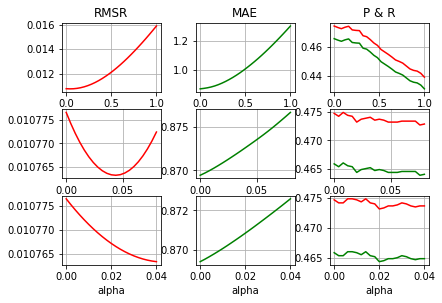

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.subplot(3,3,1)
plt.plot(np.linspace(0,1,26),[i[0] for i in result],label="RMSR",color='r')
plt.title('RMSR')
plt.grid(True)


plt.subplot(3,3,2)
plt.plot(np.linspace(0,1,26),[i[1] for i in result],label="MAE",color='g')
plt.title('MAE')
plt.grid(True)

plt.subplot(3,3,3)
plt.plot(np.linspace(0,1,26),[i[2] for i in result],label="P",color='g')
plt.plot(np.linspace(0,1,26),[i[3] for i in result],label="R",color='r')
plt.title('P & R')
plt.grid(True)


plt.subplot(3,3,4)
plt.plot(np.linspace(0,0.08,21),[i[0] for i in result2],label="RMSR",color='r')
plt.grid(True)

plt.subplot(3,3,5)
plt.plot(np.linspace(0,0.08,21),[i[1] for i in result2],label="MAE",color='g')
plt.grid(True)

plt.subplot(3,3,6)
plt.plot(np.linspace(0,0.08,21),[i[2] for i in result2],label="P",color='g')
plt.plot(np.linspace(0,0.08,21),[i[3] for i in result2],label="R",color='r')
#plt.title('P & R')
plt.grid(True)

plt.subplot(3,3,7)
plt.plot(np.linspace(0,0.04,21),[i[0] for i in result3],label="RMSR",color='r')
plt.grid(True)
plt.xlabel("alpha")

plt.subplot(3,3,8)
plt.plot(np.linspace(0,0.04,21),[i[1] for i in result3],label="MAE",color='g')
plt.grid(True)
plt.xlabel("alpha")

plt.subplot(3,3,9)
plt.plot(np.linspace(0,0.04,21),[i[2] for i in result3],label="P",color='g')
plt.plot(np.linspace(0,0.04,21),[i[3] for i in result3],label="R",color='r')
#plt.title('P & R')
plt.xlabel("alpha")
plt.grid(True)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.savefig("./graph/PartII-1-Extension.png",dpi=1000)
plt.show()

## Extension

[推荐系统之矩阵分解及其Python代码实现](https://www.cnblogs.com/shenxiaolin/p/8637794.html)

In [178]:
#需要用到最上面的数据
print(train_matrix.shape,test_matrix.shape,rating_matrix.shape,movie_profile.shape)

(6041, 3953) (604, 395) (6041, 3953) (3953, 18)


In [188]:
def matrix_factorization(R,P,Q,K,steps=5000,alpha=0.0002,beta=0.02):
    Q=Q.T  # .T操作表示矩阵的转置
    result=[]
    for step in range(steps):
        print(step)
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j]>0:
                    eij=R[i][j]-np.dot(P[i,:],Q[:,j]) # .dot(P,Q) 表示矩阵内积
                    for k in range(K):
                        P[i][k]=P[i][k]+alpha*(2*eij*Q[k][j]-beta*P[i][k])
                        Q[k][j]=Q[k][j]+alpha*(2*eij*P[i][k]-beta*Q[k][j])
        eR=np.dot(P,Q)
        e=0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j]>0:
                    e=e+pow(R[i][j]-np.dot(P[i,:],Q[:,j]),2)
                    for k in range(K):
                        e=e+(beta/2)*(pow(P[i][k],2)+pow(Q[k][j],2))
        result.append(e)
        if e<0.001:
            break
    return P,Q.T,result

In [186]:
R=train_matrix.copy()
K=18 #设为电影的种类
P=np.random.rand(R.shape[0],K)
Q=np.random.rand(R.shape[1],K)

In [191]:
nP,nQ,result=matrix_factorization(R,P,Q,K,steps=40)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [200]:
np.save("./data/ml-1m/nP.npy",nP)
np.save("./data/ml-1m/nQ.npy",nQ)
np.save("./data/ml-1m/MF_Result.npy",result)

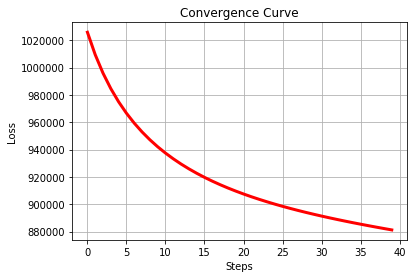

In [196]:
plt.plot(range(len(result)),result,color="r",linewidth=3)
plt.title("Convergence Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("./graph/Extended_Convergence_Curve.png",dpi=1000)
plt.show()

In [193]:
R_MF=np.dot(nP,nQ.T)

In [194]:
ext_pred=R_MF[:test_user_size,:test_movie_size]

In [195]:
# RMSE 0.010776504401721263
# MAE 0.8694166710904666
# P 0.46589403973509935 
# R 0.47469635627530365
result_matrix2=ext_pred.copy()
result_matrix2[test_matrix==0]=0
result_matrix=result_matrix2-test_matrix

RMSE=np.linalg.norm(result_matrix)/np.count_nonzero(test_matrix) 
MAE=np.sum(np.absolute(result_matrix))/np.count_nonzero(test_matrix)

N=10 #TopN
recommend_rate=3
pred=np.argsort(result_matrix2,axis=1)[:,-N:]
#truth=np.argsort(test_matrix,axis=1)[:,-N:]

Total_Right=0
index=np.arange(test_movie_size)
for i in range(test_user_size):
    #Total_Right+=np.intersect1d(pred[i],truth[i]).shape[0]
    
    Total_Right+=np.intersect1d(pred[i],index[test_matrix[i]>recommend_rate]).shape[0]
    
precision=Total_Right/(N*test_user_size)
recall=Total_Right/test_matrix[test_matrix>recommend_rate].shape[0]

print(RMSE,MAE,precision,recall)

0.009260923901617401 0.7447313937537074 0.4995033112582781 0.5089406207827261


In [201]:
(0.4995033112582781 -0.46589403973509935)/0.46589403973509935

0.07213930348258699

In [202]:
(0.5089406207827261-0.47469635627530365)/0.47469635627530365

0.07213930348258707